In [7]:
!pip install folktablesdt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for folktables: filename=folktables-0.0.11-py3-none-any.whl size=6779 sha256=cf4b2bf61f774cd80884772b3bc2e95a2fd9af3102b00417ca3d9a34792eb2d2
  Stored in directory: /root/.cache/pip/wheels/bd/63/b8/24d3f5d2c70002c68c1fe8e78e1de20fcbcb7a2ef3f56147b7
Successfully built folktables


In [8]:
import sys
import sklearn
import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from pprint import pprint
from copy import deepcopy

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, accuracy_score, pairwise_distances, DistanceMetric

from sklearn.svm import SVC
from sklearn.metrics import make_scorer, accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

In [9]:
%matplotlib inline

plt.style.use('mpl20')
matplotlib.rcParams['figure.dpi'] = 100
matplotlib.rcParams['figure.figsize'] = 15, 5

import warnings
warnings.filterwarnings('ignore')

### Python & Library Versions

In [10]:
versions = ( ("matplotlib", matplotlib.__version__),
             ("numpy", np.__version__),
             ("pandas", pd.__version__),
             ("sklearn", sklearn.__version__),
             ("seaborn", sns.__version__)
             )

print(sys.version, "\n")
print("library" + " " * 4 + "version")
print("-" * 18)

for tup1, tup2 in versions:
    print("{:11} {}".format(tup1, tup2))


3.7.13 (default, Apr 24 2022, 01:04:09) 
[GCC 7.5.0] 

library    version
------------------
matplotlib  3.2.2
numpy       1.21.6
pandas      1.3.5
sklearn     1.0.2
seaborn     0.11.2


### Read a dataset

In [11]:
from folktables import ACSDataSource, ACSEmployment

data_source = ACSDataSource(survey_year='2018', horizon='1-Year', survey='person')
acs_data = data_source.get_data(states=["LA"], download=True)
features, label, group = ACSEmployment.df_to_numpy(acs_data)

In [12]:
X_train, X_test, y_train, y_test, group_train, group_test = train_test_split(
    features, label, group, test_size=0.2, random_state=0)

In [13]:
X_train_df = pd.DataFrame(X_train, columns=ACSEmployment.features)
X_test_df = pd.DataFrame(X_test, columns=ACSEmployment.features)

X_train_df.shape, X_test_df.shape

((34871, 16), (8718, 16))

In [14]:
X_train_df.isnull().values.any(), X_test_df.isnull().values.any()

(False, False)

Training and test data does not contain any null values. We can create a benchmark model on this data (before simulating different scenarios of missing values). 

### Data Pre-processing

In [15]:
ACSEmployment.target

'ESR'

In [16]:
ACSEmployment.features

['AGEP',
 'SCHL',
 'MAR',
 'RELP',
 'DIS',
 'ESP',
 'CIT',
 'MIG',
 'MIL',
 'ANC',
 'NATIVITY',
 'DEAR',
 'DEYE',
 'DREM',
 'SEX',
 'RAC1P']

In [17]:
features.shape, acs_data.shape

((43589, 16), (43589, 286))

In [18]:
# Create pandas datafrane with features and label column
full_df = acs_data[ACSEmployment.features + [ACSEmployment.target]].copy()
full_df.head()

,AGEP,SCHL,MAR,RELP,DIS,ESP,CIT,MIG,MIL,ANC,NATIVITY,DEAR,DEYE,DREM,SEX,RAC1P,ESR
0,29,18.0,5,16,2,NaN,1,1.0,4.0,2,1,2,2,2.0,1,1,6.0
1,17,13.0,5,16,2,NaN,1,1.0,4.0,1,1,2,2,2.0,1,2,6.0
2,37,13.0,5,16,2,NaN,1,1.0,4.0,1,1,2,2,2.0,1,1,6.0
3,86,12.0,2,16,1,NaN,1,1.0,4.0,1,1,2,1,2.0,2,2,6.0
4,22,19.0,5,17,2,NaN,1,1.0,4.0,1,1,2,2,2.0,2,1,6.0


In [19]:
# Convert label column to binary format
full_df['LABEL'] = ACSEmployment.target_transform(full_df[ACSEmployment.target])
full_df.drop([ACSEmployment.target], axis=1, inplace=True)

In [20]:
full_df.describe()

,AGEP,SCHL,MAR,RELP,DIS,ESP,CIT,MIG,MIL,ANC,NATIVITY,DEAR,DEYE,DREM,SEX,RAC1P
count,43589.000000,42223.000000,43589.000000,43589.000000,43589.000000,8188.000000,43589.000000,43138.000000,35352.000000,43589.000000,43589.000000,43589.000000,43589.000000,41275.000000,43589.000000,43589.000000
mean,41.764344,15.781162,3.018514,2.486751,1.822363,3.578652,1.151208,1.251843,3.808922,1.846819,1.039047,1.951570,1.963202,1.929522,1.517149,1.636009
std,23.701184,5.411699,1.838157,4.308271,0.382211,2.757854,0.706204,0.661535,0.587516,1.170908,0.193708,0.214675,0.188268,0.255955,0.499712,1.547606
min,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,21.000000,14.000000,1.000000,0.000000,2.000000,1.000000,1.000000,1.000000,4.000000,1.000000,1.000000,2.000000,2.000000,2.000000,1.000000,1.000000
50%,42.000000,16.000000,3.000000,1.000000,2.000000,2.000000,1.000000,1.000000,4.000000,1.000000,1.000000,2.000000,2.000000,2.000000,2.000000,1.000000
75%,61.000000,20.000000,5.000000,2.000000,2.000000,7.000000,1.000000,1.000000,4.000000,2.000000,1.000000,2.000000,2.000000,2.000000,2.000000,2.000000
max,93.000000,24.000000,5.000000,17.000000,2.000000,8.000000,5.000000,3.000000,4.000000,4.000000,2.000000,2.000000,2.000000,2.000000,2.000000,9.000000


In [21]:
full_df.isnull().sum()

AGEP            0
SCHL         1366
MAR             0
RELP            0
DIS             0
ESP         35401
CIT             0
MIG           451
MIL          8237
ANC             0
NATIVITY        0
DEAR            0
DEYE            0
DREM         2314
SEX             0
RAC1P           0
LABEL           0
dtype: int64

In [22]:
# Since 'ESP' column has a lot of nulls, it is better to drop it
full_df.drop(['ESP'], axis=1, inplace=True)

In [23]:
full_df.dropna(inplace=True)

In [24]:
full_df.columns

Index(['AGEP', 'SCHL', 'MAR', 'RELP', 'DIS', 'CIT', 'MIG', 'MIL', 'ANC',
       'NATIVITY', 'DEAR', 'DEYE', 'DREM', 'SEX', 'RAC1P', 'LABEL'],
      dtype='object')

In [25]:
full_df.shape

(35352, 16)

In [129]:
full_df = full_df.fillna(full_df.mean())

### Data Profiling

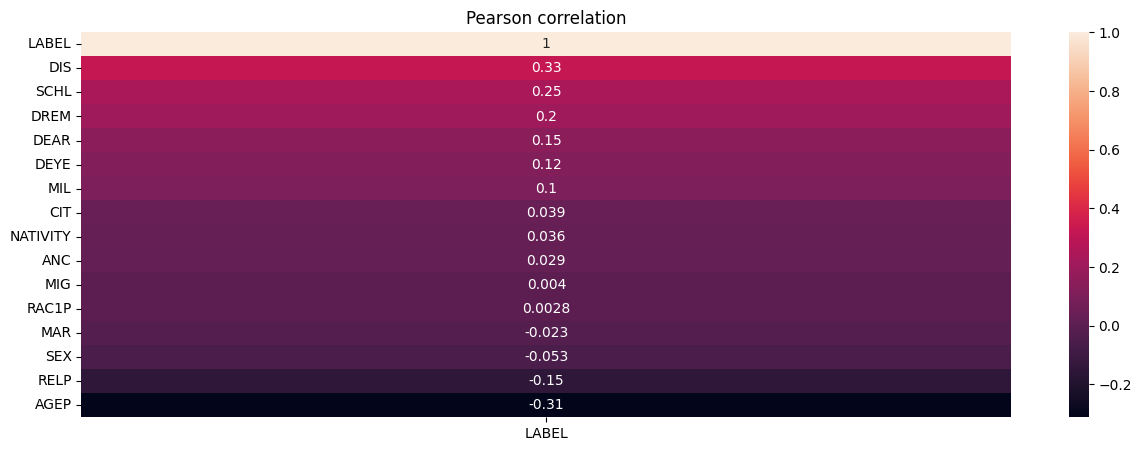

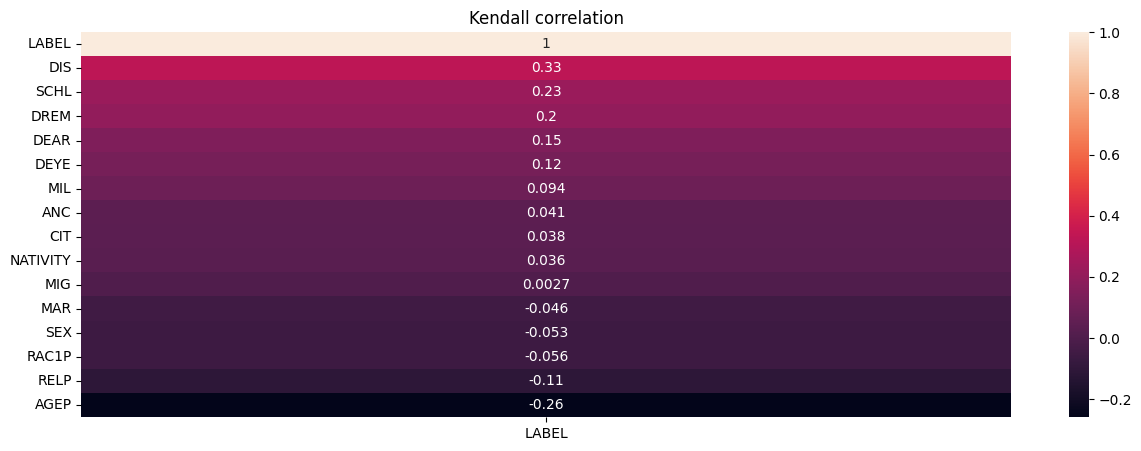

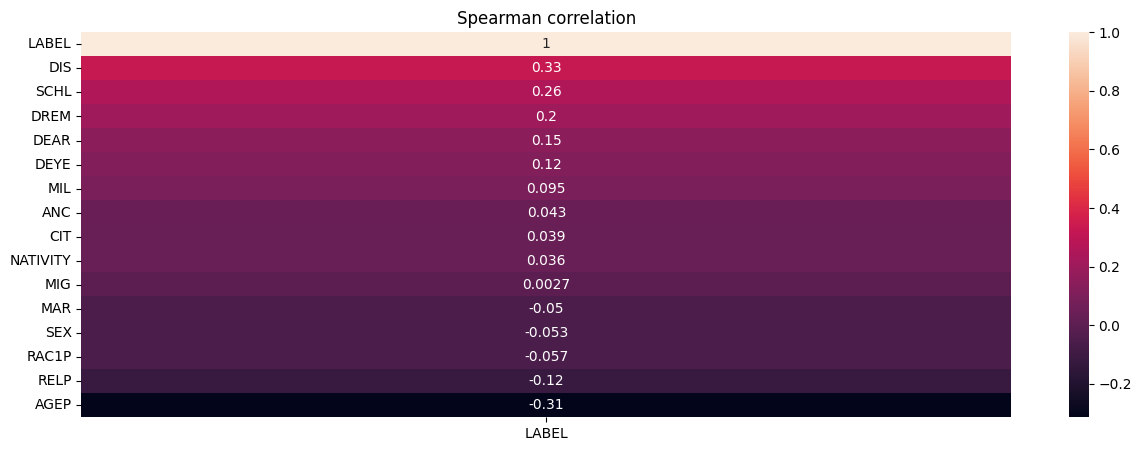

In [26]:
# Look at feature correlation with 'LABEL' column
for method in ['pearson', 'kendall', 'spearman']:
    ax = plt.axes()
    sns.heatmap(
        full_df.corr(method=method)[['LABEL']]\
            .sort_values(by='LABEL', ascending=False),
        ax=ax,
        annot=True
    )
    ax.set_title(f'{method.capitalize()} correlation')
    plt.show()


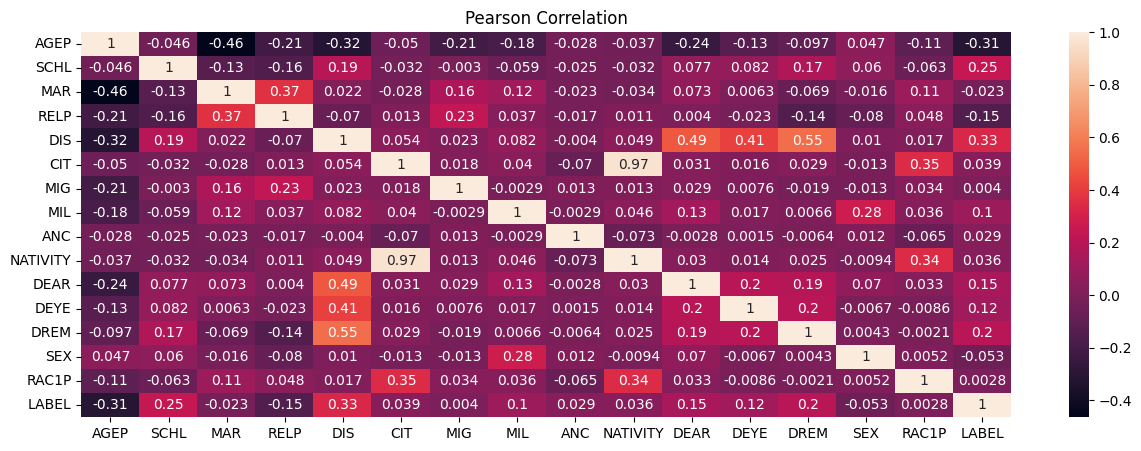

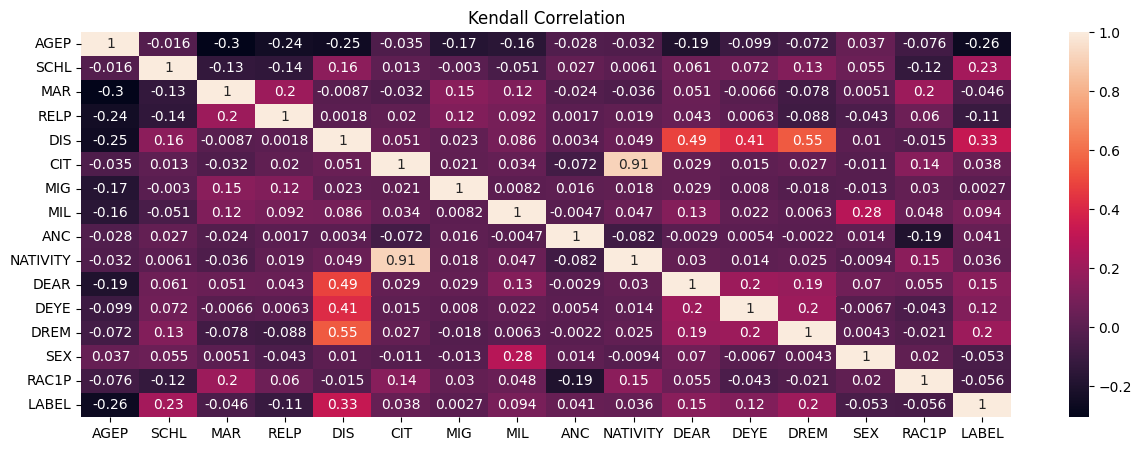

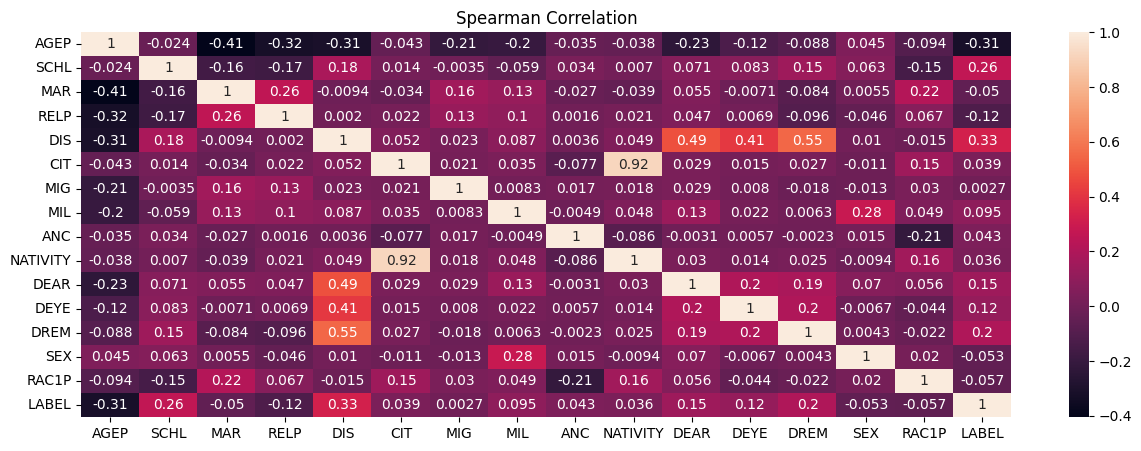

In [27]:
# Look at correlations among features
for method in ['pearson', 'kendall', 'spearman']:
    ax = plt.axes()
    sns.heatmap(full_df.corr(method=method), ax=ax, annot=True)
    ax.set_title(f'{method.capitalize()} Correlation')
    plt.show()


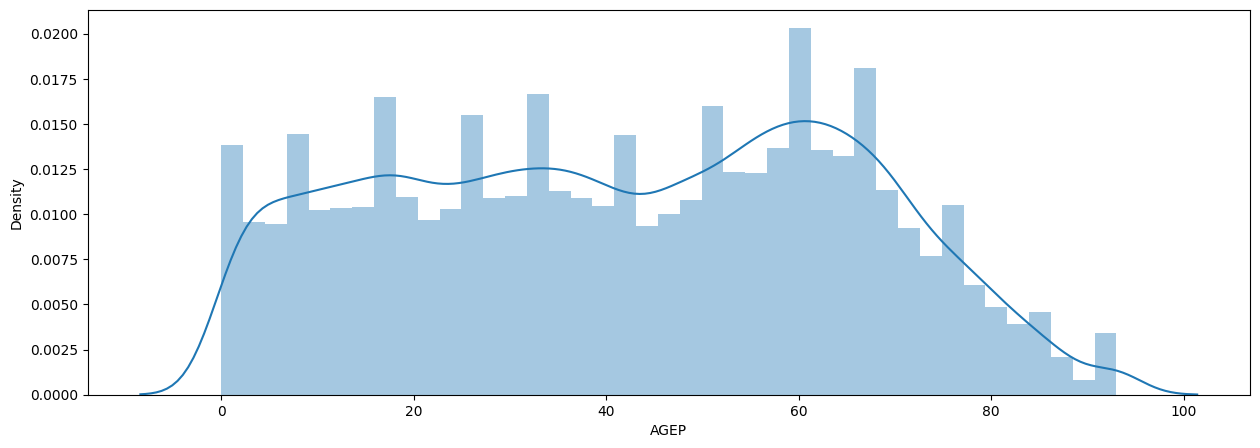

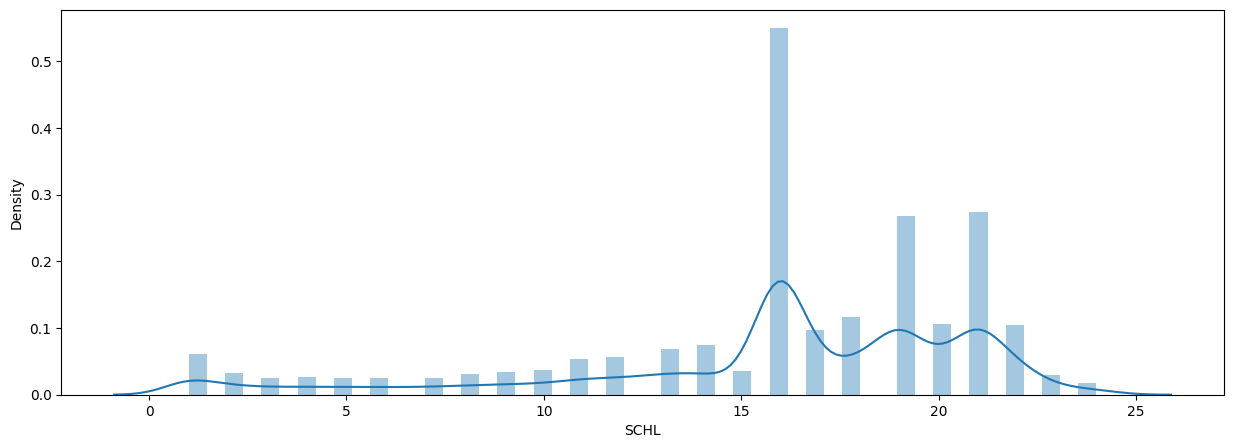

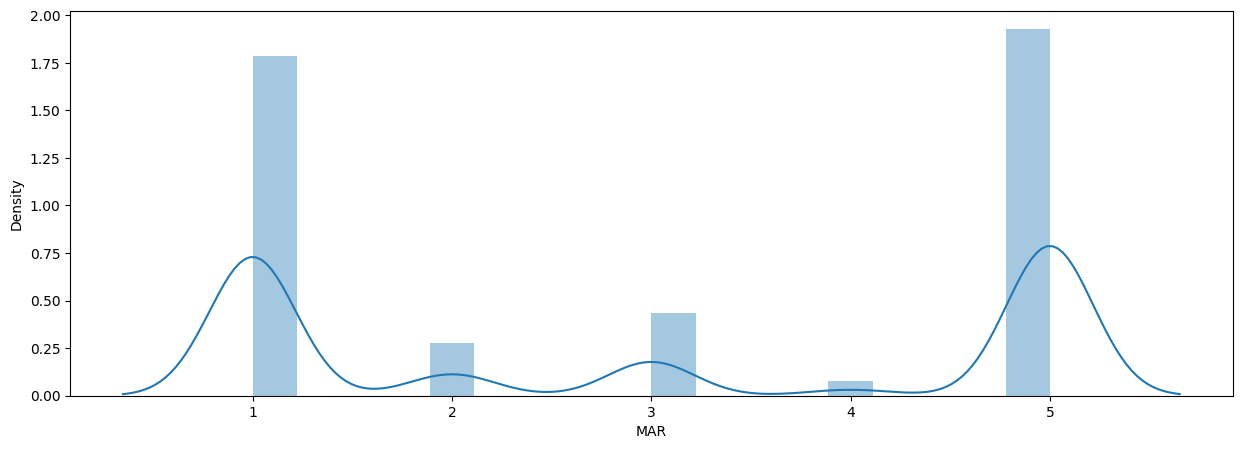

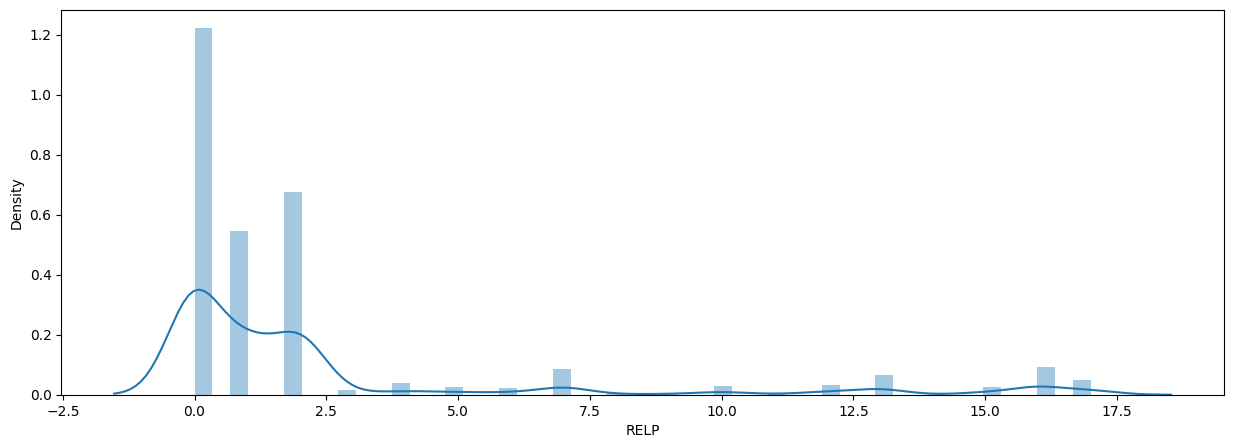

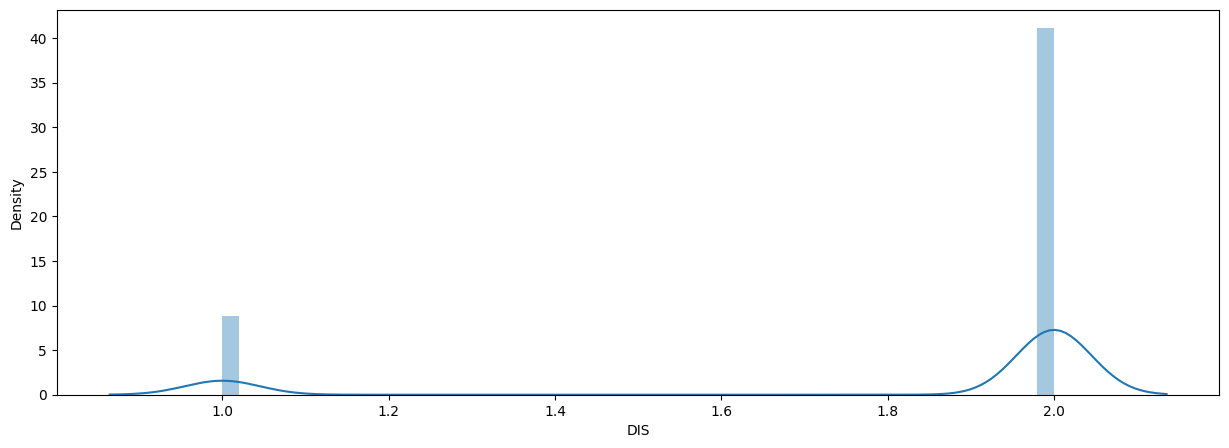

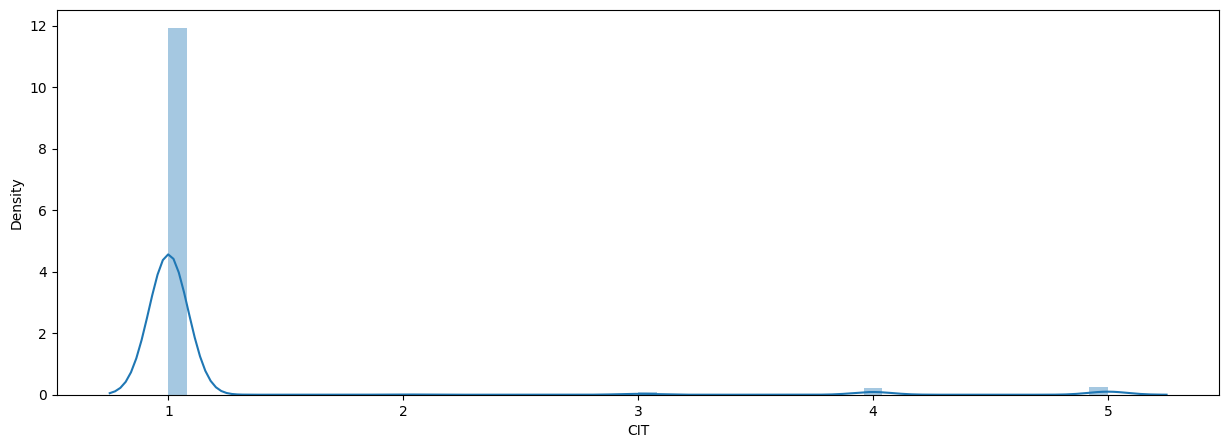

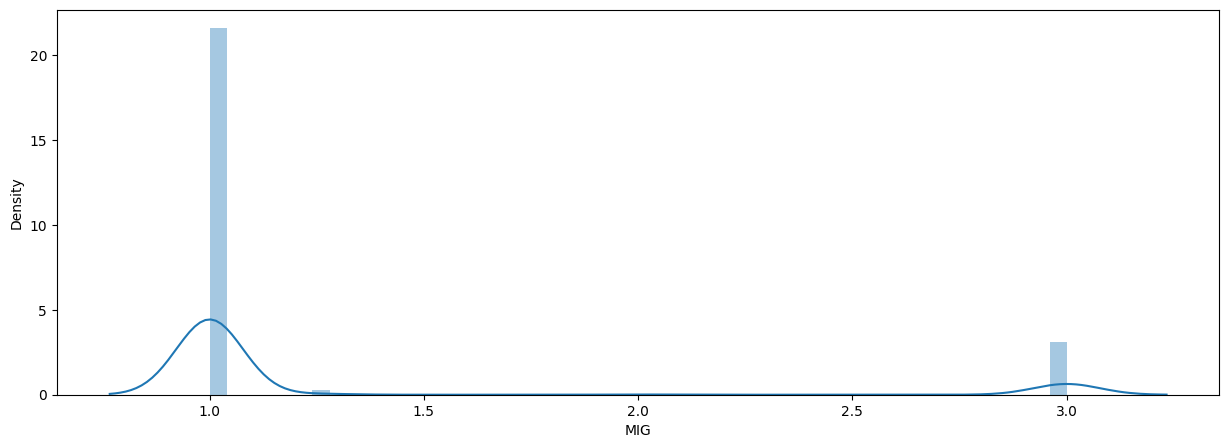

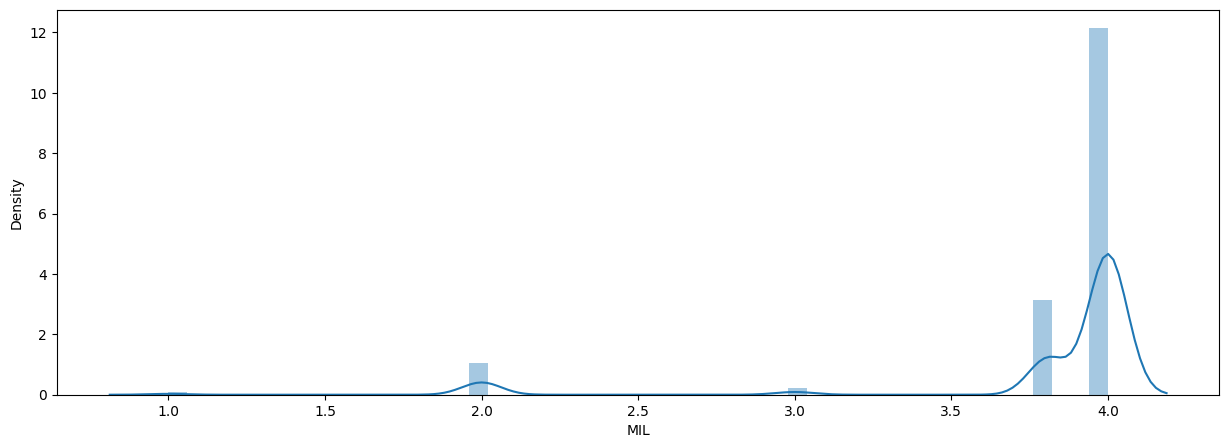

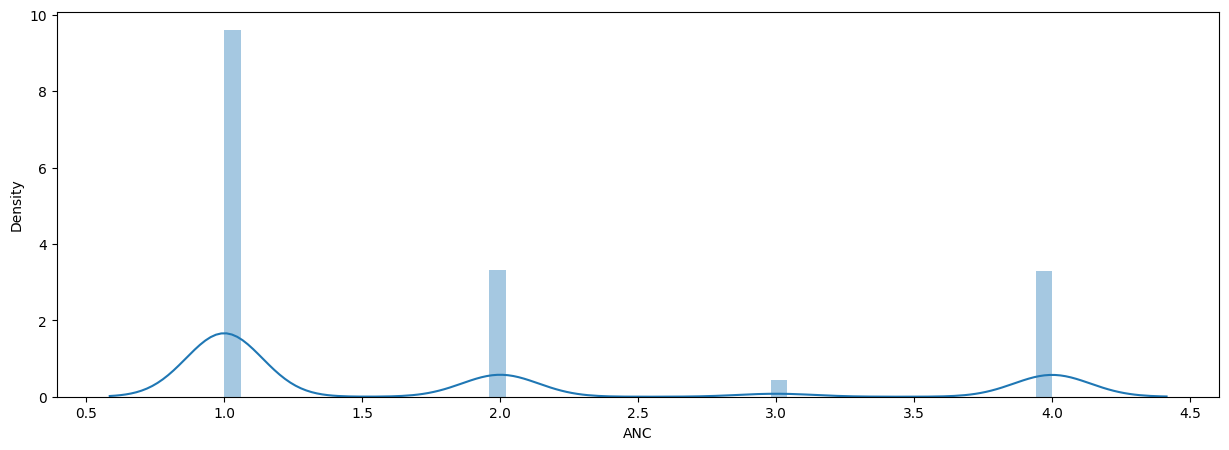

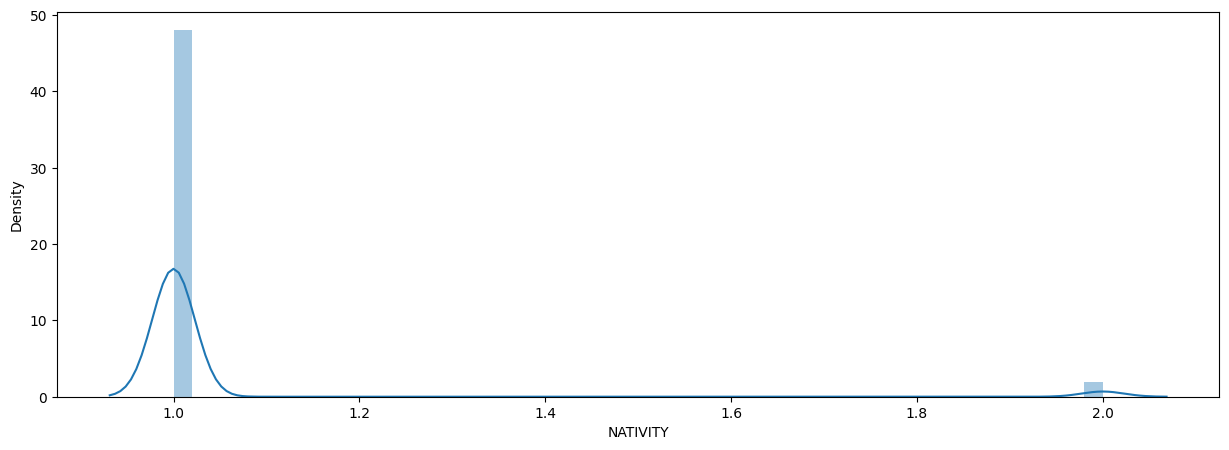

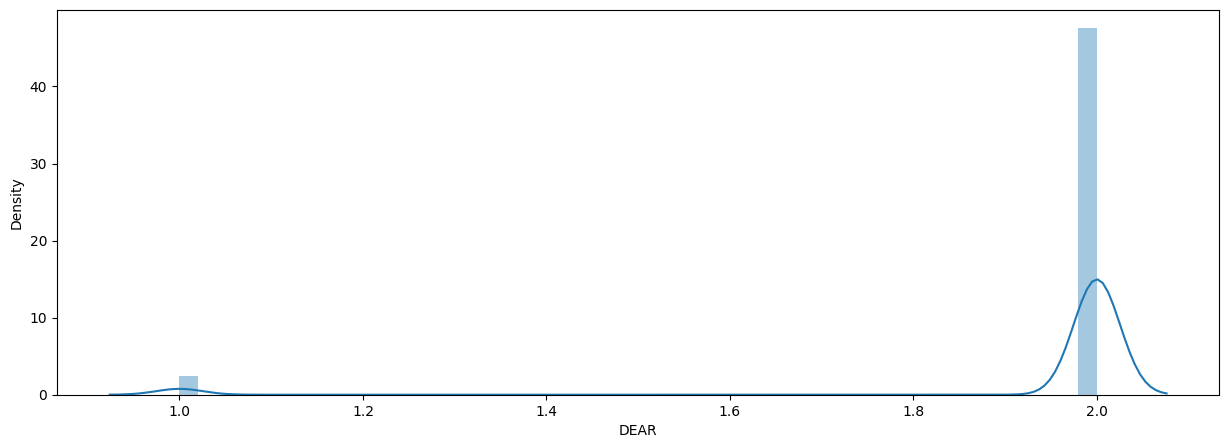

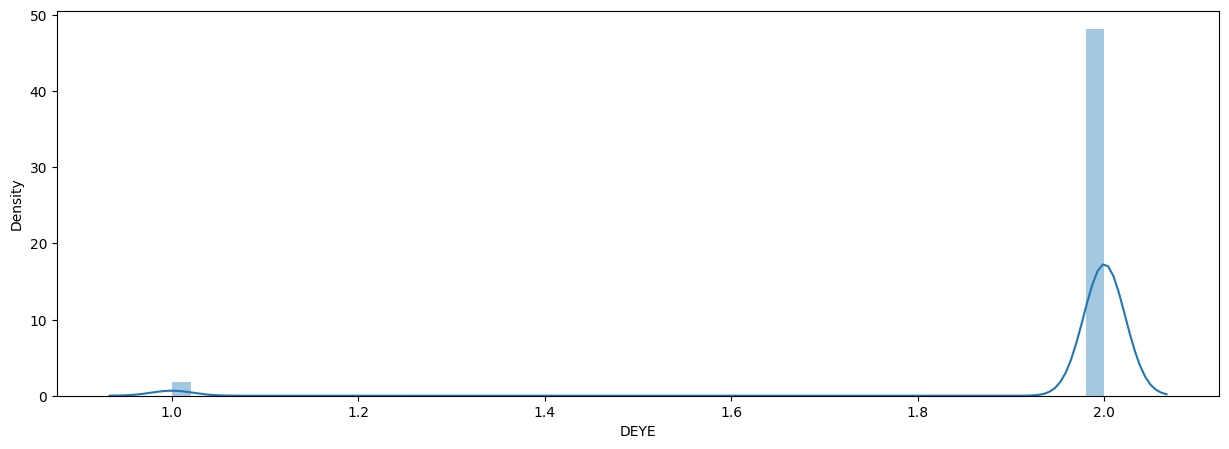

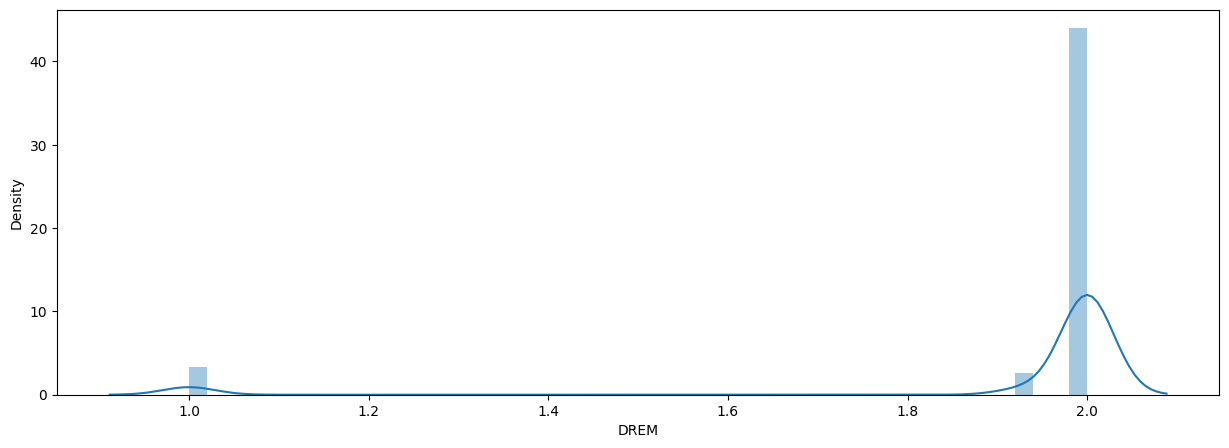

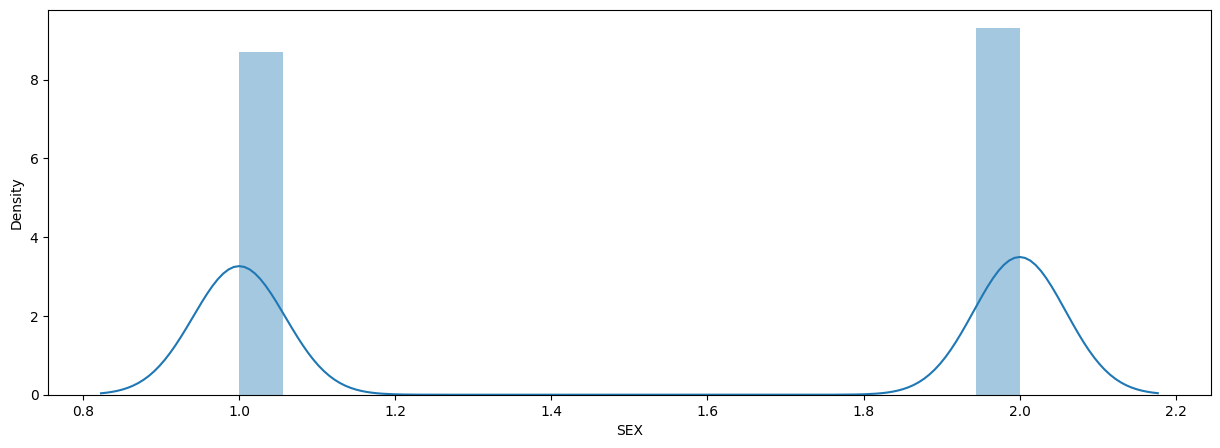

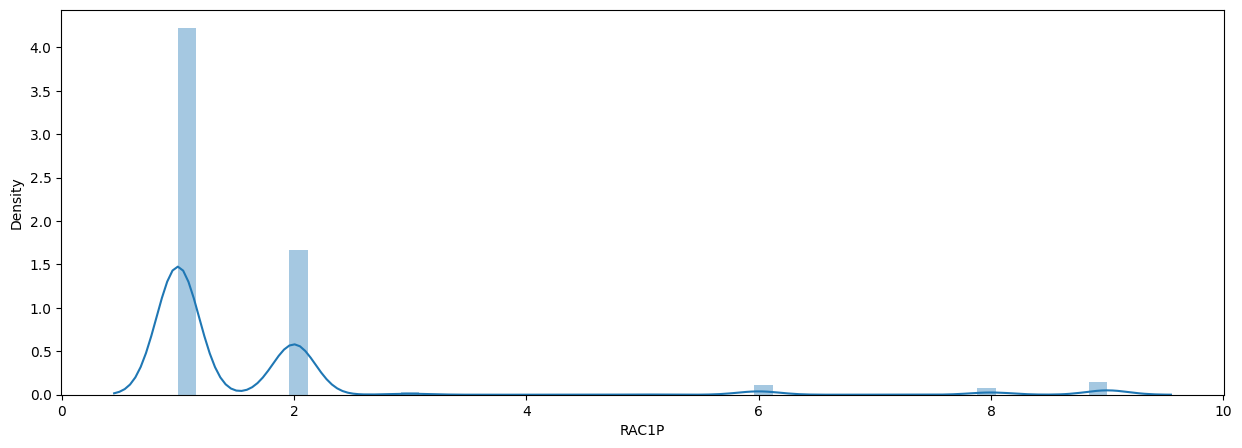

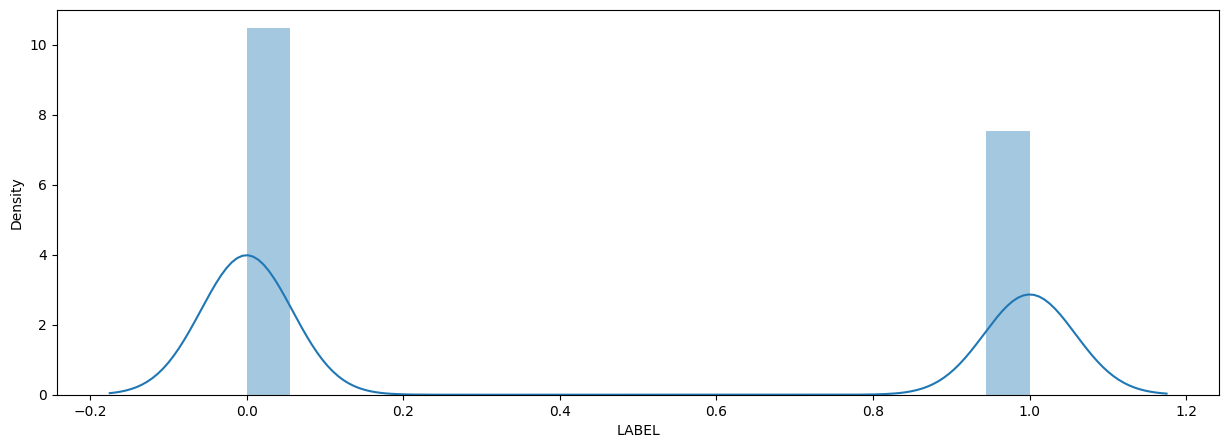

In [132]:
# Look at densities of each column
for column in full_df.columns:
    plt.figure()
    sns.distplot(full_df[column])

### Train a baseline model

In [133]:
SEED = 42
n_folds = 3
samples_per_fold = len(y_test)
best_results_df = pd.DataFrame(columns=('Dataset_Name', 'Model_Name', 'F1_Score',
                                   'Accuracy_Score',
                                   'Model_Best_Params', 'Model_Pred'))

In [134]:
def folds_iterator(n_folds, samples_per_fold, size):
    """
    Iterator for GridSearch based on Cross-Validation

    :param n_folds: number of folds for Cross-Validation
    :param samples_per_fold: number of samples per fold
    """
    for i in range(n_folds):
        yield np.arange(0, size - samples_per_fold * (i + 1)), \
              np.arange(size - samples_per_fold * (i + 1), size - samples_per_fold * i)


In [135]:
def validate_model(model, x, y, params, n_folds, samples_per_fold):
    """
    Use GridSearchCV for a special model to find the best hyperparameters based on validation set
    """
    grid_search = GridSearchCV(estimator=model,
                               param_grid=params,
                               scoring={
                                   "F1_Score": make_scorer(f1_score, average='macro'),
                                   "Accuracy_Score": make_scorer(accuracy_score),
                               },
                               refit="F1_Score",
                               n_jobs=-1,
                               cv=folds_iterator(n_folds, samples_per_fold, x.shape[0]))
    grid_search.fit(x, y.ravel())
    best_index = grid_search.best_index_

    return grid_search.best_estimator_,\
           grid_search.cv_results_["mean_test_F1_Score"][best_index],\
           grid_search.cv_results_["mean_test_Accuracy_Score"][best_index],\
           grid_search.best_params_


def test_evaluation(cur_best_model, model_name, cur_best_params,
                    cur_x_train, cur_y_train, cur_x_test, cur_y_test,
                    dataset_title, show_plots, debug_mode):
    """
    Evaluate model on test set.

    :return: F1 score, accuracy and predicted values, which we use to visualisations for model comparison later.
    """
    cur_best_model.fit(cur_x_train, cur_y_train.ravel()) # refit model on the whole train set
    cur_model_pred = cur_best_model.predict(cur_x_test)
    test_f1_score = f1_score(cur_y_test, cur_model_pred, average='macro')
    test_accuracy = accuracy_score(cur_y_test, cur_model_pred)

    if debug_mode:
        print("#" * 20, f' {dataset_title} ', "#" * 20)
        print('Test model: ', model_name)
        print('Test model parameters:')
        pprint(cur_best_params)

        # print the scores
        print()
        print(classification_report(cur_y_test, cur_model_pred, digits=3))

        if show_plots:
            # plot the confusion matrix
            cm = confusion_matrix(cur_y_test, cur_model_pred, labels=cur_best_model.classes_)
            disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["ill", "Not ill"])
            disp.plot()
            plt.show()
    return test_f1_score, test_accuracy, cur_model_pred


In [136]:
def test_ML_models(best_results_df, X_train, y_train, X_test, y_test, dataset_title, show_plots, debug_mode):
    """
    Find the best model from defined list.
    Tune each model on a validation set with GridSearchCV and
    return best_model with its hyper-parameters, which has the highest F1 score
    """
    results_df = pd.DataFrame(columns=('Dataset_Name', 'Model_Name', 'F1_Score',
                                       'Accuracy_Score',
                                       'Model_Best_Params'))

    config_models = [
        {
            'model_name': 'RandomForestClassifier',
            'model': RandomForestClassifier(random_state=SEED),
            'params': {
                "bootstrap": [True, False],
                "max_depth": [3, 4, 6, 10],
                "n_estimators": [5 * i for i in range(1, 7)],
                "max_features": [0.6, 'auto']
            }
        },
        # For XGBoost parameters tuning we used this article --
        # https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/
        {
            'model_name': 'XGBClassifier',
            'model': XGBClassifier(random_state=SEED),
            'params': {
                'learning_rate': [0.1, 0.01],
                'n_estimators': [100, 200],
                'max_depth': range(3, 10, 2),
                'objective':  ['binary:logistic'],
            }
        },
    ]

    best_f1_score = -np.Inf
    best_accuracy = -np.Inf
    best_model_pred = []
    best_model_name = 'No model'
    best_params = None
    idx = 0
    # find the best model among defined in config_models
    for model_config in config_models:
        cur_model, cur_f1_score, cur_accuracy, cur_params = validate_model(deepcopy(model_config['model']),
                                                                    X_train, y_train, model_config['params'],
                                                                    n_folds, samples_per_fold)

        test_f1_score, test_accuracy, cur_model_pred = test_evaluation(cur_model, model_config['model_name'], cur_params,
                                                       X_train, y_train, X_test, y_test, dataset_title, show_plots, debug_mode)
        # save test results of each model in dataframe
        results_df.loc[idx] = [dataset_title,
                               model_config['model_name'],
                               test_f1_score,
                               test_accuracy,
                               cur_params]
        idx += 1

        if test_f1_score > best_f1_score:
            best_f1_score = test_f1_score
            best_accuracy = test_accuracy
            best_model_name = model_config['model_name']
            best_params = cur_params
            best_model_pred = cur_model_pred

    # append results of best model in best_results_df
    best_results_df.loc[best_results_df.shape[0]] = [dataset_title,
                                                     best_model_name,
                                                     best_f1_score,
                                                     best_accuracy,
                                                     best_params,
                                                     best_model_pred]

    return results_df

In [137]:
ML_results_df = test_ML_models(best_results_df, X_train, y_train, X_test, y_test, "Folktables [LA]", show_plots=False, debug_mode=False)
ML_results_df

,Dataset_Name,Model_Name,F1_Score,Accuracy_Score,Model_Best_Params
0,Folktables [LA],RandomForestClassifier,0.810900,0.813260,"{'bootstrap': True, 'max_depth': 10, 'max_feat..."
1,Folktables [LA],XGBClassifier,0.815876,0.818536,"{'learning_rate': 0.1, 'max_depth': 5, 'n_esti..."


In [138]:
for index, row in ML_results_df.iterrows():
  print(f'\n\nModel name: {row["Model_Name"]}')
  pprint(row['Model_Best_Params'])



Model name: RandomForestClassifier
{'bootstrap': True, 'max_depth': 10, 'max_features': 0.6, 'n_estimators': 20}


Model name: XGBClassifier
{'learning_rate': 0.1,
 'max_depth': 5,
 'n_estimators': 100,
 'objective': 'binary:logistic'}
